# 迁移学习 Transfer Learning

## 迁移学习的原理

我们有许多模型都取得了很好的效果，如下图，Inception与ResNet。我们想利用这些模型进行分类。该怎么办呢？

![img](./img/notes/tf-1.png)

我们可以使用迁移学习的方法来做到这一点。**迁移学习**的原理是用大型数据集训练过的神经网络能够将它所学的知识运用到之前从未见过的数据集上。因为我们将现有的模型学到的知识迁移到新的数据集上，因此我们称为迁移学习。

为了进行迁移学习，我们需要更改预训练模型的最后一个层级，因为每个数据集都有不同数量的输出类别，例如，ImageNet有1000个类别，但是Fashion MNIST数据集有10个类别，而猫狗数据集只有2个类别。

![img](./img/notes/tf-2.png)

![img](./img/notes/tf-3.png)

![img](./img/notes/tf-4.png)

所以我们需要更改现有模型的最后一个层级，使其类别数量与数据集的类别数量一样。

并且，在训练过程中，不能修改模型的预训练部分。方法是将预训练模型的变量设为不可训练，称之为冻结模型(Freezing Model)。冻结之后，只有最后分类层级的变量会接受训练。预训练模型的其他层级中的变量将保持不变。这么做的另一个好处是可以大大缩短训练时间。因为我们只训练最后分类层级的变量，而不用训练整个模型。如果不冻结预训练模型，模型学习的特征将在训练过程中改变，这是以内新的分类层级没有接受训练，所以在训练时，权重将随机初始化。如果随机初始化权重，模型将犯很大的错误，这些错误会反向传播到预训练模型中，导致错误地更新预训练模型中已经拥有的权重。所以**一定记住，在迁移学习时，一定要冻结预训练模型的参数**

![img](./img/notes/tf-5.png)



## MobileNet

Inception与ResNet都有着很深的层级，并且众多参数。虽然准确度很高，但是训练和预测时间都会较慢，并且消耗很多的计算资源。这里我们使用一个先进的卷积神经网络，叫做MobileNet。它采用了一个非常高效的神经网络结构，能够尽量降低模型所需的内存和计算资源，同时保障很高的准确率，这使MobileNet成为在内存和计算资源有限的移动设备上的理想模型。MobileNet由Google开发，用ImageNet数据集进行了训练。由于它是在ImageNet上训练，所有有1000个输出类别，远远超出了猫狗数据集中的两个类别。为了进行迁移学习，我们需要下载MobileNet特征，不包含分类层级。

在TensorFlow中，下载的特征可以作为普通的KerasLayer，并且采用特定的输入大小。

因为MobileNet是在ImageNet上训练的，所以输入大小必须与训练过程中使用的大小一致。MobileNet是用大小固定的RGB图像(`224*224`)训练的。

TensorFlow有一个预训练模型代码库，称为TensorFlow Hub。TensorFlow Hub上有删除最后一个分类层级的预训练模型。

![img](./img/notes/tf-6.png)

在代码中使用预训练模型很简单，可以直接使用URL引用模型，然后将预训练模型当作KerasLayer嵌入序列模型中，接着向模型末尾添加分类层级。添加的密集层将是新的分类器，需要接受训练，可以像上面那样进行训练。

## 【实例】对猫狗数据集应用迁移学习

### 添加引用

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

%matplotlib inline

### Part1:使用TensorFlow Hub MobileNet进行预测
#### 下载classifier

In [2]:
# 原有是https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 不过貌似不行
# CLASSIFIER_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
CLASSIFIER_URL ="https://hub.tensorflow.google.cn/google/tf2-preview/mobilenet_v2/classification/4"

IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

#### 在单张图片上执行预测

MobileNet在ImageNet上训练的。ImageNet有1000个类别，其中有一个是军服。我们用一个不在ImageNet上的军服来看看是否能够预测。

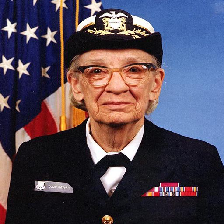

In [3]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

In [4]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

记住，模型总是希望在批处理图像上执行

In [5]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

得到的结果是包含1001个元素的向量，这个向量包含了属于某个类别的概率

In [6]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

#### 解析预测

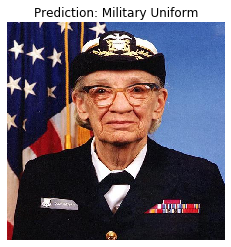

In [7]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

### Part2:在猫狗数据集上使用TensorFlow Hub模型
#### 数据集

In [8]:
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

splits = tfds.Split.ALL.subsplit(weighted=(80, 20))

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

猫狗数据集不是同样大小的：

In [9]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (500, 343, 3)
Image 2 shape: (375, 500, 3)
Image 3 shape: (375, 500, 3)


所以我们需要把其转换为MobileNet需要的(224,224).

其中`.repeat()`与`steps_per_epoch`不是必须的，但是这会在每个周期节约15秒左右，因为shuffle缓冲区只需要冷启动一次

In [10]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

#### 在一个图像batch执行分类器

先用之前的`model`对象在猫狗数据集上执行一次预测

In [11]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Egyptian cat', 'Persian cat', 'groenendael', 'Egyptian cat',
       'Leonberg', 'Labrador retriever', 'mouse', 'orangutan',
       'Egyptian cat', 'Persian cat', 'Persian cat', 'Scotch terrier',
       'Egyptian cat', 'Persian cat', 'tabby', 'Egyptian cat',
       'Pomeranian', 'Egyptian cat', 'American Staffordshire terrier',
       'tabby', 'tiger cat', 'lynx', 'Egyptian cat', 'whippet', 'kelpie',
       'Egyptian cat', 'Siamese cat', 'English springer', 'Egyptian cat',
       'Egyptian cat', 'tabby', 'Egyptian cat'], dtype='<U30')

然后做个图看看结果

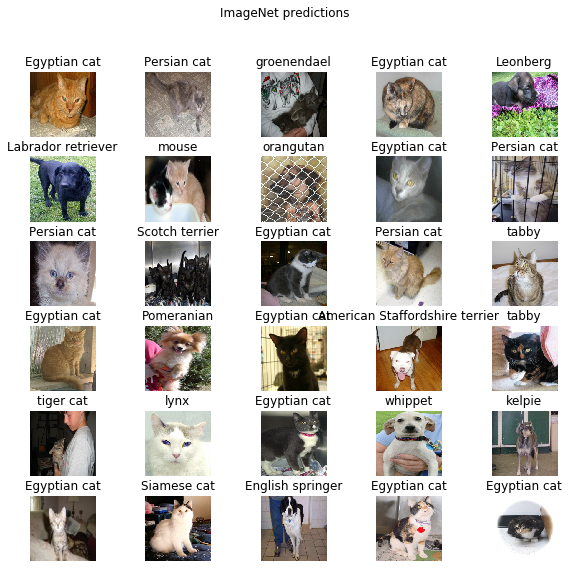

In [12]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

### Part3:使用TensorFlow Hub上做简单的迁移学习

除了完整的模型外，TensorFlow Hub也包含没有分类层的模型，这些可以很容易就用于迁移学习。

在TensorFlow Hub上，没有分类层的部分模型称之为`feature_extractor`。因为它做了除了分类之外所有的特征提取工作。

In [13]:
# URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
URL = "https://hub.tensorflow.google.cn/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

我们在上面跑一个batch的图像。输出的shape里，32是图片数量，1280是最有一层神经元的数量

In [14]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


冻结模型

In [15]:
feature_extractor.trainable = False

#### 添加分类

In [16]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


#### 训练模型

In [17]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================]536 - accuracy: 0.53 - 4s 2s/step - loss: 0.7135 - accuracy: 0.54 - 5s 2s/step - loss: 0.6498 - accuracy: 0.61 - 5s 1s/step - loss: 0.6309 - accuracy: 0.65 - 5s 940ms/step - loss: 0.5671 - accuracy: 0.712 - 5s 797ms/step - loss: 0.5246 - accuracy: 0.755 - 5s 695ms/step - loss: 0.4926 - accuracy: 0.776 - 5s 619ms/step - loss: 0.4638 - accuracy: 0.793 - 5s 560ms/step - loss: 0.4334 - accuracy: 0.816 - 5s 512ms/step - loss: 0.4105 - accuracy: 0.828 - 5s 473ms/step - loss: 0.3886 - accuracy: 0.838 - 5s 441ms/step - loss: 0.3701 - accuracy: 0.846 - 5s 414ms/step - loss: 0.3580 - accuracy: 0.851 - 5s 390ms/step - loss: 0.3402 - accuracy: 0.861 - 6s 370ms/step - loss: 0.3271 - accuracy: 0.868 - 6s 351ms/step - loss: 0.3217 - accuracy: 0.873 - 6s 336ms/step - loss: 0.3089 - accuracy: 0.880 - 6s 322ms/step - loss: 0.2955 - accuracy: 0.887 - 6s 310ms/step - loss: 0.2865 - accuracy: 0.891 - 6s 298ms/step - loss: 0.2754 - accuracy: 0.896 - 6s 288ms

可以看到，验证集精度提高到 。[这里](https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet.py)可以看到如何使用Keras创建MobileNet

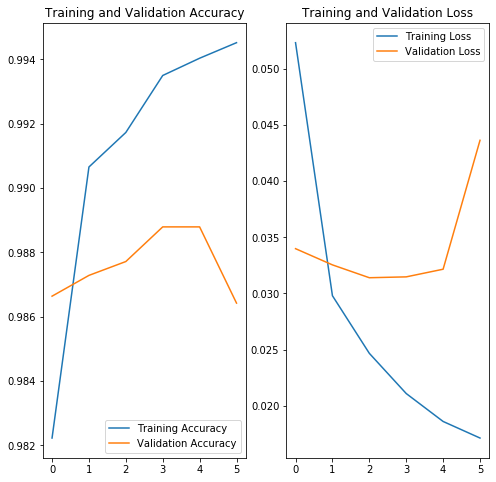

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 检查预测

In [19]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [20]:
# Run the image batch through the model and convert the indices to class names.
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat',
       'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat',
       'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat',
       'dog', 'cat', 'cat', 'cat', 'cat'], dtype='<U3')

In [21]:
# Let's look at the true labels and predicted ones.
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0]
Predicted labels:  [0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0]


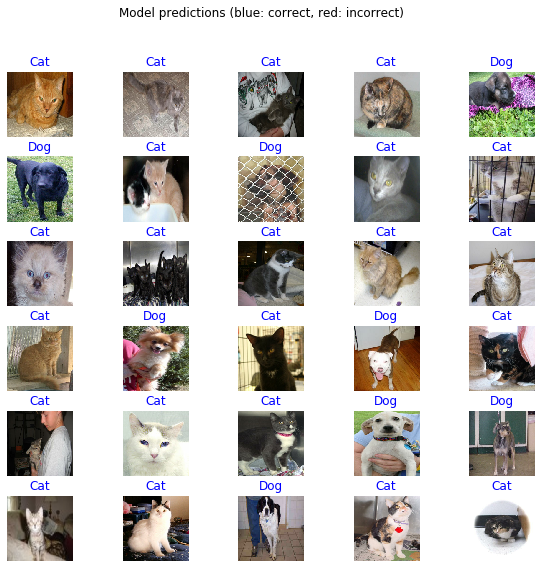

In [22]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")